In [6]:
import numpy as np
from __future__ import print_function
import time, os, json
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
import keras

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [42]:
# load data
flows_data_1 = np.load("flows_data_part1.npy")
flows_data_2 = np.load("flows_data_part2.npy")
imu_data_1 = np.load("imu_data_part1.npy")
imu_data_2 = np.load("imu_data_part2.npy")
y_1 = np.load("labels_part1.npy")
y_2 = np.load("labels_part2.npy")

flows_data = np.concatenate((flows_data_1, flows_data_2), axis=0)
imu_data = np.concatenate((imu_data_1, imu_data_2), axis=0)
y_data = np.concatenate((y_1,y_2), axis=0)
print("flows_data.shape",flows_data.shape)
print("imu_data.shape", imu_data.shape)
print("y_data.shape", y_data.shape)
N,H,W,C = flows_data.shape
N, imu_H = imu_data.shape
N, y_H = y_data.shape

flows_data.shape (2000, 48, 64, 2)
imu_data.shape (2000, 6)
y_data.shape (2000, 3)


In [43]:
N_training = int(0.7*flows_data.shape[0])
N_validation = flows_data.shape[0]- N_training
training_data_indices = np.random.choice(np.arange(flows_data.shape[0]), N_training)
validation_data_indices = np.setdiff1d(np.arange(flows_data.shape[0]), training_data_indices)

<function matplotlib.pyplot.show>

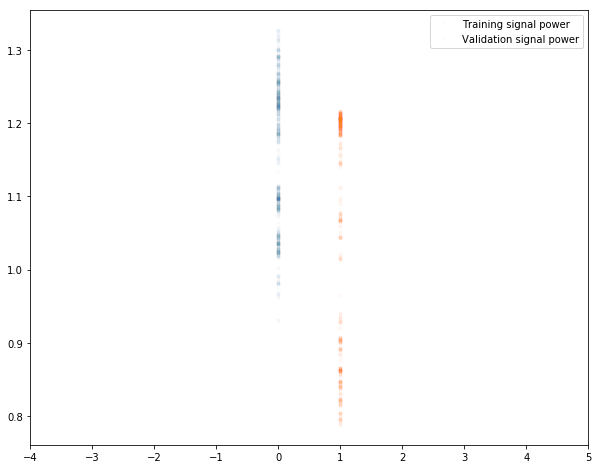

In [44]:
# Check that the signal is relatively evenly distributed between train/val
val_dist = []
train_dist = []
n_samp = 1000
for k in range(n_samp):
    x,x2,y,i = sample_minibatch(400);
    err = calc_rmse(np.zeros_like(y),y);
    train_dist.append(err)
    
    x,x2,y,i = sample_minibatch(400,False);
    err = calc_rmse(np.zeros_like(y),y);
    val_dist.append(err)


plt.plot(np.zeros(n_samp), train_dist,'.',alpha=0.01)
plt.plot(np.ones(n_samp), val_dist,'.',alpha=0.01)
plt.xlim([-4,5])
plt.legend(['Training signal power', 'Validation signal power'])
plt.show

In [71]:
# define model
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, LSTM
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Reshape, Flatten
from keras.layers.merge import concatenate
from keras import losses
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM

minibatch_dim = 32
sequence_length = 10 # really the sliding window backprop length. 
n_windows = 6

# placeholder for images
img_inputs = Input(batch_shape=(minibatch_dim,sequence_length,H,W,C)) # truly: (minibatch_dim, seq_len, H, W, C)
# process images
interm = TimeDistributed(Conv2D(64, 3, strides=2, padding='valid', data_format="channels_last", activation='relu'))(img_inputs)
#interm = TimeDistributed(MaxPooling2D(pool_size=(1,3), strides=(1,2), padding = 'valid'))(interm)
extracted_image_features =  TimeDistributed(Flatten())(interm)
# placeholder for imu data
imu_inputs = Input(batch_shape=(minibatch_dim,sequence_length, imu_H))
# process imu data
extracted_imu_features = TimeDistributed(Dense(32, activation='relu'))(imu_inputs)

# concat together
top_out = concatenate([extracted_image_features, extracted_imu_features])

In [72]:
# have data of shape: minibatchsize X seq_length X 22112 after other layers
out = LSTM(3,activation='elu',stateful=True)(top_out)

# define model
model = Model(inputs=[img_inputs, imu_inputs], outputs=out)


In [80]:
def sample_minibatch(n_windows, sliding_window_length, minibatch_dim, train=True,iseq=None):
    sequence_length = sliding_window_length
    x_img_batch = np.zeros((n_windows, minibatch_dim, sequence_length, flows_data.shape[1], flows_data.shape[2], flows_data.shape[3]))
    x_imu_batch = np.zeros((n_windows, minibatch_dim, sequence_length, imu_data.shape[1]))
    y_batch = np.zeros((n_windows, minibatch_dim, sequence_length, y_data.shape[1]))
    
    for window in range(n_windows):
        for sample in range(minibatch_dim):
            if(iseq is None):
                # randomly sample endpoint:
                # choose which subsequence to sample from: 
                if(train):
                    i_stop = 0
                    while i_stop - sequence_length < 0:
        #                i_stop = training_data_indices[np.random.randint(0,N_training)]
                        i_stop = np.random.randint(0,N_training)
                else:
                    i_stop = 0
                    while i_stop - sequence_length < 0:
                        i_stop = N_training + np.random.randint(0,N_validation)
        #                i_stop = validation_data_indices[np.random.randint(0,N_validation)]
            else:
                i_stop = iseq
            x_imu_batch[window,sample,:,:] = imu_data[i_stop-sequence_length:i_stop,:]
            y_batch[window,sample,:,:] = y_data[i_stop-sequence_length:i_stop,:]
            x_img_batch[window,sample,:,:,:,:] = flows_data[i_stop-sequence_length:i_stop,:,:,:]
            if(x_imu_batch.shape[0] == 0 or x_img_batch.shape[0]==0):
                print(i_stop,sequence_length)

    return x_imu_batch, x_img_batch, y_batch, i_stop

def calc_rmse(predictions, targets):
    
    return np.sqrt(((predictions.reshape([-1]) - targets.reshape([-1])) ** 2).mean())

In [81]:
model.compile(optimizer='SGD', loss='mean_squared_error')

In [88]:
epochs = 10

In [95]:
class LossHistory(keras.callbacks.Callback):
    def __init__(self):
        self.losses = []
    
    def on_train_begin(self, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()

for e in range(epochs):
    print("Epoch",e, "/",epochs)
    for j in range(int(N/minibatch_dim/sequence_length)): # one epoch
        x_imu, x_img, y, i = sample_minibatch(6, 10, 32, train=True)
        for i in range(n_windows):
            x_train_img = x_img[i,:,:,:,:,:]
            x_train_imu = x_imu[i,:,:,:]
            y_train = y[i,:,-1,:]
            model.fit(x=[x_train_img, x_train_imu], y=y_train, verbose=0, callbacks=[history])
    

Epoch 0 / 10
Epoch 1 / 10
Epoch 2 / 10
Epoch 3 / 10
Epoch 4 / 10
Epoch 5 / 10
Epoch 6 / 10
Epoch 7 / 10
Epoch 8 / 10
Epoch 9 / 10


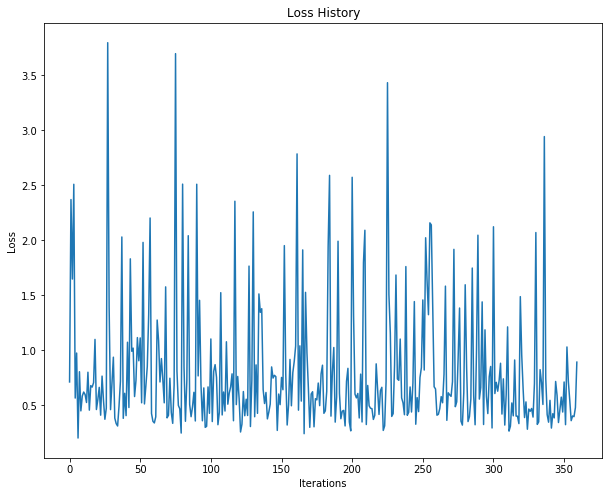

In [98]:
plt.plot(range(len(history.losses)), history.losses)
plt.title("Loss History")
plt.xlabel("Iterations")
plt.ylabel("Loss")

In [ ]:
model.predict()